In [46]:
#La clase Model para manejar los agentes y la clase Agent para un definir un agente.
from mesa import Agent, Model

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime

MAXVAL = 10000

In [47]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
            self.model.clean_cells += 1
            self.model.movements += 1
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.model.movements += 1
                
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    #print (grid)
    return grid
    
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        self.clean_cells = width * height - (width * height * dirty_cells_percentage)
        self.movements = 0
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (1, 1))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        amount = int((width * height) * dirty_cells_percentage)
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
        #print(self.floor)
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
    
    def get_clean_cells_percentage(self):
        return self.clean_cells / (self.grid.width * self.grid.height)
    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()

In [56]:
# Definimos el tamaño del Grid
GRID_SIZE = 50

# Definimos el número máximo de generaciones a correr se utilizará para que la animacion no tarde tanto
MAX_GENERATIONS = 200

# Definimos el número de agentes
NUM_AGENTS = 10

# Definimos el porcentaje de celdas sucias
DIRTY_CELLS_PERC = 1

# Definimos el tiempo máximo de ejecución
MAX_TIME = 15

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

# Definimos un contador de generaciones
generations_counter = 0

model = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, DIRTY_CELLS_PERC )
i = 1
while not model.is_all_clean() and time.time() - start_time < MAX_TIME:
    generations_counter += 1
    model.step()
    i += 1
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print('Porcentaje de celdas limpias:', model.get_clean_cells_percentage())
print("Movimientos totales realizados por los agentes:", model.movements)
print("Generaciones totales:", generations_counter)

Tiempo de ejecución: 0:00:13.866340
Porcentaje de celdas limpias: 1.0
Movimientos totales realizados por los agentes: 60584
Generaciones totales: 6245


In [57]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

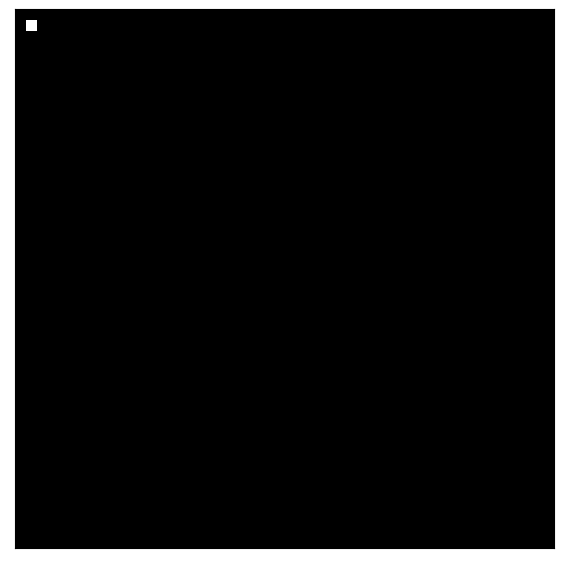

In [58]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [59]:
anim